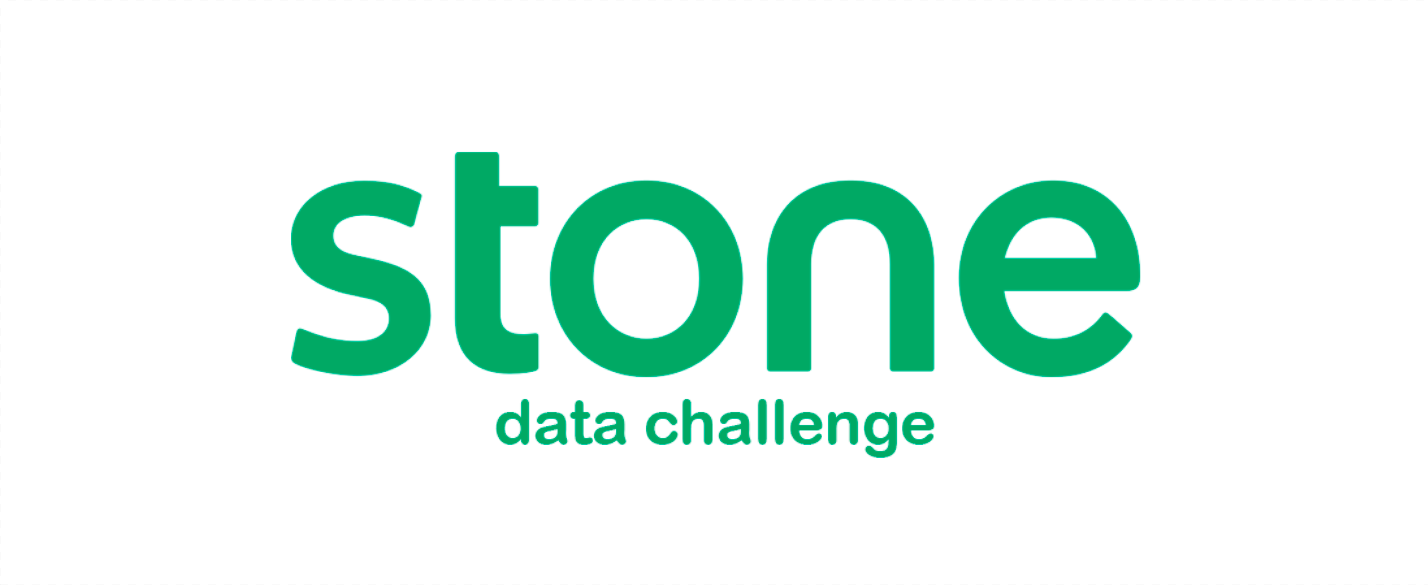

#### **Objetivo do Modelo**:
* Para cada um dos mais de 200 mil clientes, estimar o TPV mensal de Agosto à Dezembro de 2020. A métrica a ser utilizada na avaliação é o erro absoluto relativo. 


#### **Metodologia**:
* **Preparação dos Dados**:
    * Parsing e decomposição das datas
    * Feature Engineering (label encoding, agrupamento, redução de categorias e muitos outros - mais detalhes no script `preprocessing.py`)
    * Imputação de valores utilizando FFill.
    * Padronização da variável Estado
    * Criação de Lags e Diffs do TPV-Mensal


* **Baselines**
    * Média dos últimos meses (com vazamento de dados)
    * Média dos últimos meses (sem vazamento de dados)
    * TPV do último mes (só se aplica para validação)
    
    
* **Definição do Modelo**
    * Devido ao alto número de features categóricas e categorias, decidi por modelos ensemble.
    * Foram treinados modelos em 3 algoritmos diferentes - RandomForest, CatBoost e LightGBM
        * RandomForest foi escolhido por ser um bom baseline com hiperparâmetros padrão.
        * Além da ótima perfomance padrão, o CatBoost foi escolhido por funcionar muito bem com dados categóricos.
        * LightGBM lida muito bem com categóricos label encoded e permite maior controle dos hiperparâmetros, permitindo alcançar métricas melhores.
    * RandomForest foi descartado por não ser eficiente com esse volume de dados.
    
    
* **Hiperparametrização**:
    * Utilizei o Optuna (integrado ao LightGBM e API padrão).


* **Modelo Final**
    * CatBoost.


* **Métricas de Avaliação**
    * MAE e MSE - Mean Absolut/Squared Error. Se aproxima muito da métrica utilizada no desafio e a segunda força a redução do erro em empresas de porte maior, que terão maior peso na média.
    * Idealmente, eu acredito que para esse problema o uso do RMLSE poderia ser interessante também (considerando o range que o TPV-Value pode alcançar)


* **Validação**
    * O dataset foi separado em set de treino e teste de forma aleatória.
    * Os modelos foram treinados no set de treino**, utilizando validação sliding window entre os meses de Março e Julho.
        * **A única exceção foi o RandomForest, devido à ineficiência nesse volume de dados.
    * Em seguida, os modelos foram aplicados no set de teste para verificar a capacidade de generalização.
    
    
* **Dataset Resultante**:
    * `previsoes_ago_dez_version_2.csv`

### Iniando o Notebook

In [1]:
# Import libs

# Wrangling e Analysis
import pandas as pd
import numpy as np

# Dataviz
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.ensemble import RandomForestRegressor
import catboost as cb
import optuna
import lightgbm as lgb

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import shap

# Pre-Written Modelling Functions
from ml_functions import model_validation

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)

**OBS.:** O LightGBM não oferece suporte para suprimir alguns warnings e como estou utilizando um loop para realizar o sliding window, as células que treinam o modelo acabam tendo um output bem poluído. O filtro abaixo só foi implementado após o término do treinamento para que o notebook ficasse mais limpo.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import nos datasets

# df_modelo - será separado em train, test
df_modelo = pd.read_csv('data/df_modelo.csv', parse_dates=['mes_referencia'])

# df_future - será utilizado para treinar os modelo entregável, além de funcionar como y_true
df_future = pd.read_csv('data/df_treino_final.csv', parse_dates=['mes_referencia'])

# df_past - será utilizado para validação dos modelos (meses 3 à 7 com tpv_mensal em branco)
df_past = pd.read_csv('data/df_predict_mar.csv', parse_dates=['mes_referencia'])

for dataframe in (df_modelo, df_past, df_future):
    dataframe.drop("Unnamed: 0", axis=1, inplace=True)
    dataframe.sort_values(['mes_referencia', 'id'], inplace=True)
    dataframe['TPV_mensal'] = dataframe['TPV_mensal'].fillna(0)

In [4]:
df_modelo[df_modelo.Ano == 2020].head()

id mes_referencia  TPV_mensal  Mês  Trimestre   Ano  tpv_ultimo_mes  \
13   1     2020-01-31   11,491.87    1          1  2020       25,856.14   
31   3     2020-01-31    1,851.80    1          1  2020        2,304.90   
65   4     2020-01-31   69,948.98    1          1  2020       45,585.60   
84   5     2020-01-31      734.40    1          1  2020           60.00   
94   6     2020-01-31   59,561.00    1          1  2020       54,129.96   

    diff_ultimo_mes  tpv_ultimo-1_mes  diff_ultimo-1_mes  tpv_ultimo-2_mes  \
13        10,815.64         15,040.50           4,857.35         10,183.15   
31           501.00          1,803.90            -506.35          2,310.25   
65         8,440.79         37,144.81         -10,756.86         47,901.67   
84          -971.00          1,031.00             348.00            683.00   
94        12,968.50         41,161.46           2,085.68         39,075.78   

    diff_ultimo-2_mes  tpv_ultimo-3_mes  diff_ultimo-3_mes  tpv_ultimo-4_mes  \
13          -3,056.55         13,239.70          -2,808.65         16,048.35   
31             331.30          1,978.95            -865.10          2,844.05   
65          -2,688.43         50,590.10          -3,747.39         54,337.49   
84             -39.00            722.00            -382.50          1,104.50   
94          38,838.17            237.61                nan               nan   

    diff_ultimo-4_mes  tpv_ultimo-5_mes  diff_ultimo-5_mes  tpv_ultimo-6_mes  \
13             250.16         15,798.19           5,869.74          9,928.45   
31            -447.70          3,291.75           1,896.05          1,395.70   
65          13,714.34         40,623.15          -3,120.57         43,743.72   
84              83.60          1,020.90             235.90            785.00   
94                nan               nan                nan               nan   

    diff_ultimo-6_mes  tpv_ultimo-7_mes  diff_ultimo-7_mes  tpv_ultimo-8_mes  \
13             297.85          9,630.60           2,928.90          6,701.70   
31                nan               nan                nan               nan   
65          -7,584.66         51,328.38           3,351.24         47,977.14   
84             100.00            685.00              49.00            636.00   
94                nan               nan                nan               nan   

    diff_ultimo-8_mes  tpv_ultimo-9_mes  diff_ultimo-9_mes  tpv_ultimo-10_mes  \
13          -3,068.05          9,769.75           5,422.45           4,347.30   
31                nan               nan                nan                nan   
65          -5,494.22         53,471.36         -24,055.31          77,526.67   
84            -286.80            922.80             142.30             780.50   
94                nan               nan                nan                nan   

    diff_ultimo-10_mes  tpv_ultimo-11_mes  diff_ultimo-11_mes  MCC  \
13           -1,675.85           6,023.15           -4,084.75   73   
31                 nan                nan                 nan   37   
65           -4,791.01          82,317.68           40,234.88    9   
84              750.50              30.00                 nan   56   
94                 nan                nan                 nan   42   

    MacroClassificacao  is_missing_MacroClassificacao  segmento  \
13                   7                              0        14   
31                   6                              0        28   
65                   4                              0        15   
84                   4                              0        26   
94                   0                              0         0   

    is_missing_segmento  sub_segmento  is_missing_sub_segmento  persona  \
13                    0            20                        0       11   
31                    0            35                        0        2   
65                    0            27                        0       11   
84                    0       

In [5]:
df_past[df_past.Ano == 2020].head()

id mes_referencia  TPV_mensal  Mês  Trimestre   Ano  tpv_ultimo_mes  \
13   1     2020-01-31   11,491.87    1          1  2020       25,856.14   
27   3     2020-01-31    1,851.80    1          1  2020        2,304.90   
61   4     2020-01-31   69,948.98    1          1  2020       45,585.60   
80   5     2020-01-31      734.40    1          1  2020           60.00   
91   6     2020-01-31   59,561.00    1          1  2020       54,129.96   

    diff_ultimo_mes  tpv_ultimo-1_mes  diff_ultimo-1_mes  tpv_ultimo-2_mes  \
13        10,815.64         15,040.50           4,857.35         10,183.15   
27           501.00          1,803.90            -506.35          2,310.25   
61         8,440.79         37,144.81         -10,756.86         47,901.67   
80          -971.00          1,031.00             348.00            683.00   
91        12,968.50         41,161.46           2,085.68         39,075.78   

    diff_ultimo-2_mes  tpv_ultimo-3_mes  diff_ultimo-3_mes  tpv_ultimo-4_mes  \
13          -3,056.55         13,239.70          -2,808.65         16,048.35   
27             331.30          1,978.95            -865.10          2,844.05   
61          -2,688.43         50,590.10          -3,747.39         54,337.49   
80             -39.00            722.00            -382.50          1,104.50   
91          38,838.17            237.61                nan               nan   

    diff_ultimo-4_mes  tpv_ultimo-5_mes  diff_ultimo-5_mes  tpv_ultimo-6_mes  \
13             250.16         15,798.19           5,869.74          9,928.45   
27            -447.70          3,291.75           1,896.05          1,395.70   
61          13,714.34         40,623.15          -3,120.57         43,743.72   
80              83.60          1,020.90             235.90            785.00   
91                nan               nan                nan               nan   

    diff_ultimo-6_mes  tpv_ultimo-7_mes  diff_ultimo-7_mes  tpv_ultimo-8_mes  \
13             297.85          9,630.60           2,928.90          6,701.70   
27                nan               nan                nan               nan   
61          -7,584.66         51,328.38           3,351.24         47,977.14   
80             100.00            685.00              49.00            636.00   
91                nan               nan                nan               nan   

    diff_ultimo-8_mes  tpv_ultimo-9_mes  diff_ultimo-9_mes  tpv_ultimo-10_mes  \
13          -3,068.05          9,769.75           5,422.45           4,347.30   
27                nan               nan                nan                nan   
61          -5,494.22         53,471.36         -24,055.31          77,526.67   
80            -286.80            922.80             142.30             780.50   
91                nan               nan                nan                nan   

    diff_ultimo-10_mes  tpv_ultimo-11_mes  diff_ultimo-11_mes  MCC  \
13           -1,675.85           6,023.15           -4,084.75   73   
27                 nan                nan                 nan   37   
61           -4,791.01          82,317.68           40,234.88    9   
80              750.50              30.00                 nan   56   
91                 nan                nan                 nan   42   

    MacroClassificacao  is_missing_MacroClassificacao  segmento  \
13                   7                              0        14   
27                   6                              0        28   
61                   4                              0        15   
80                   4                              0        26   
91                   0                              0         0   

    is_missing_segmento  sub_segmento  is_missing_sub_segmento  persona  \
13                    0            20                        0       11   
27                    0            35                        0        2   
61                    0            27                        0       11   
80                    0       

In [6]:
df_future[df_future.Ano == 2020].head()

id mes_referencia  TPV_mensal  Mês  Trimestre   Ano  tpv_ultimo_mes  \
13    1     2020-01-31   11,491.87    1          1  2020       25,856.14   
41    3     2020-01-31    1,851.80    1          1  2020        2,304.90   
80    4     2020-01-31   69,948.98    1          1  2020       45,585.60   
104   5     2020-01-31      734.40    1          1  2020           60.00   
119   6     2020-01-31   59,561.00    1          1  2020       54,129.96   

     diff_ultimo_mes  tpv_ultimo-1_mes  diff_ultimo-1_mes  tpv_ultimo-2_mes  \
13         10,815.64         15,040.50           4,857.35         10,183.15   
41            501.00          1,803.90            -506.35          2,310.25   
80          8,440.79         37,144.81         -10,756.86         47,901.67   
104          -971.00          1,031.00             348.00            683.00   
119        12,968.50         41,161.46           2,085.68         39,075.78   

     diff_ultimo-2_mes  tpv_ultimo-3_mes  diff_ultimo-3_mes  tpv_ultimo-4_mes  \
13           -3,056.55         13,239.70          -2,808.65         16,048.35   
41              331.30          1,978.95            -865.10          2,844.05   
80           -2,688.43         50,590.10          -3,747.39         54,337.49   
104             -39.00            722.00            -382.50          1,104.50   
119          38,838.17            237.61                nan               nan   

     diff_ultimo-4_mes  tpv_ultimo-5_mes  diff_ultimo-5_mes  tpv_ultimo-6_mes  \
13              250.16         15,798.19           5,869.74          9,928.45   
41             -447.70          3,291.75           1,896.05          1,395.70   
80           13,714.34         40,623.15          -3,120.57         43,743.72   
104              83.60          1,020.90             235.90            785.00   
119                nan               nan                nan               nan   

     diff_ultimo-6_mes  tpv_ultimo-7_mes  diff_ultimo-7_mes  tpv_ultimo-8_mes  \
13              297.85          9,630.60           2,928.90          6,701.70   
41                 nan               nan                nan               nan   
80           -7,584.66         51,328.38           3,351.24         47,977.14   
104             100.00            685.00              49.00            636.00   
119                nan               nan                nan               nan   

     diff_ultimo-8_mes  tpv_ultimo-9_mes  diff_ultimo-9_mes  \
13           -3,068.05          9,769.75           5,422.45   
41                 nan               nan                nan   
80           -5,494.22         53,471.36         -24,055.31   
104            -286.80            922.80             142.30   
119                nan               nan                nan   

     tpv_ultimo-10_mes  diff_ultimo-10_mes  tpv_ultimo-11_mes  \
13            4,347.30           -1,675.85           6,023.15   
41                 nan                 nan                nan   
80           77,526.67           -4,791.01          82,317.68   
104             780.50              750.50              30.00   
119                nan                 nan                nan   

     diff_ultimo-11_mes  MCC  MacroClassificacao  \
13            -4,084.75   73                   7   
41                  nan   37                   6   
80            40,234.88    9                   4   
104                 nan   56                   4   
119                 nan   42                   0   

     is_missing_MacroClassificacao  segmento  is_missing_segmento  \
13                               0        14                    0   
41                               0        28                    0   
80                               0        15                    0   
104                              0        26                    0   
119                              0         0                    0   

     sub_segmento  is_missing_sub_segmento  persona  porte  tipo_documento  \
13             20                   

In [4]:
# Separando dataframes - train e test set
all_ids = np.array(df_future.id.unique())

np.random.seed(42)
test_ids = np.random.choice(all_ids, size=round(0.15*len(all_ids)))

df_test = df_modelo[df_modelo.id.isin(test_ids)]
df_train = df_modelo[~df_modelo.id.isin(test_ids)]

df_past_test = df_past[df_past.id.isin(test_ids)]
df_past_train = df_past[~df_past.id.isin(test_ids)]

df_future_test = df_future[df_future.id.isin(test_ids)]
df_future_train = df_future[~df_future.id.isin(test_ids)]

Uma vez separados os sets de treino e de teste e confirmado que está tudo correto, podemos calcular o score baseline. Irei utilizar os últimos meses do dataset (Mar/2020 - Jul/2020) para testar o funcionamento dos modelos. Após a previsão do primeiro mês, o modelo incorporará o mês previsto para prever o próximo (sliding window). 

### Baselines

Irei utilizar 4 baselines para comparar os resultados.

* Erro comparando a venda atual com a venda do último mês.
    * Esse é um score baseline considerado relativamente forte para séries temporais, principalmente quando atribuídas à vendas ou saídas de produto.
* Erro comparando a venda atual com a média das vendas até o mês atual.
    * Definido de acordo com o PDF do case.
* Erro comparando a venda atual com a média das vendas até o mês de fevereiro.
    * Definido de acordo com o PDF do case - "uso atual". 
* Erro comparando a venda atual com a média das vendas incluindo o mês atual e seguintes, se aplicável.
    * Também definido de acordo com o PDF do case, nesse caso ocorre vazamento de dados o que aumenta o score.
    

In [8]:
# Definindo Baselines - #1 Venda do Ultimo Mes

mean_sq_error = []
mean_error = []

for mes in range(3,8):
    val = df_train[(df_train['Ano'] == 2020) & (df_train['Mês'] == mes)]

    val = val.fillna(0)
    pred = val['tpv_ultimo_mes'].values

    sqr_error = mean_squared_error(val['TPV_mensal'].values, pred)
    error = mean_absolute_error(val['TPV_mensal'].values, pred)
    
    print('Mês %d - Erro Quadrado %.5f      - Erro Absoluto %.5f' % (mes, sqr_error, error))
    mean_sq_error.append(sqr_error)
    mean_error.append(error)
    
print('Média Erro Quadrado = %.5f      - Média Erro Absoluto %.5f' % (np.mean(mean_sq_error), np.mean(mean_error)))

Mês 3 - Erro Quadrado 681729315.08537      - Erro Absoluto 7490.14150
Mês 4 - Erro Quadrado 358095605.61061      - Erro Absoluto 7544.06240
Mês 5 - Erro Quadrado 211326978.59817      - Erro Absoluto 6555.97363
Mês 6 - Erro Quadrado 197834376.84456      - Erro Absoluto 5691.07836
Mês 7 - Erro Quadrado 177010566.96613      - Erro Absoluto 6123.64362
Média Erro Quadrado = 325199368.62097      - Média Erro Absoluto 6680.97990


In [9]:
# Definindo Baselines - #2 Média de todos os últimos meses

mean_error = []
mean_sq_error = []

for mes in range(3,8):     
    val = df_train[(df_train['Ano'] == 2020) & (df_train['Mês'] == mes)]
    ids = val['id'].unique()  
    pred = df_train[(df_train['id'].isin(ids))].groupby('id')['TPV_mensal'].mean()

    sqr_error = mean_squared_error(val['TPV_mensal'].values, pred)
    error = mean_absolute_error(val['TPV_mensal'].values, pred)
    
    print('Mês %d - Erro Quadrado %.5f      - Erro Absoluto %.5f' % (mes, sqr_error, error))
    mean_sq_error.append(sqr_error)
    mean_error.append(error)
    
print('Média Erro Quadrado = %.5f      - Média Erro Absoluto %.5f' % \
      (np.mean(mean_sq_error), np.mean(mean_error)))

Mês 3 - Erro Quadrado 427551797.36149      - Erro Absoluto 6589.17186
Mês 4 - Erro Quadrado 730432233.90851      - Erro Absoluto 8705.23750
Mês 5 - Erro Quadrado 699455484.97461      - Erro Absoluto 8215.67843
Mês 6 - Erro Quadrado 645478279.49912      - Erro Absoluto 7805.07531
Mês 7 - Erro Quadrado 699526725.67094      - Erro Absoluto 9413.33451
Média Erro Quadrado = 640488904.28294      - Média Erro Absoluto 8145.69952


In [10]:
# Definindo Baselines - #3 Média dos últimos meses (nao conta em frente)

mean_sq_error = []
mean_error = []

for mes in range(3,8):     
    val = df_train[(df_train['Ano'] == 2020) & (df_train['Mês'] == mes)]
    ids = val['id'].unique()
    
    pred = df_train[(df_train['id'].isin(ids)) & (df_train['mes_referencia'] < np.datetime64(f'2020-0{mes+1}'))]\
                                                                            .groupby('id')['TPV_mensal']\
                                                                            .mean()
    sqr_error = mean_squared_error(val['TPV_mensal'].values, pred)
    error = mean_absolute_error(val['TPV_mensal'].values, pred)
    
    print('Mês %d - Erro Quadrado %.5f      - Erro Absoluto %.5f' % (mes, sqr_error, error))
    mean_sq_error.append(sqr_error)
    mean_error.append(error)
    
print('Média Erro Quadrado = %.5f      - Média Erro Absoluto %.5f' % (np.mean(mean_sq_error), np.mean(mean_error)))

Mês 3 - Erro Quadrado 560238473.03814      - Erro Absoluto 6942.39260
Mês 4 - Erro Quadrado 881247364.23930      - Erro Absoluto 9223.32410
Mês 5 - Erro Quadrado 803561623.70998      - Erro Absoluto 8936.66330
Mês 6 - Erro Quadrado 702691328.81375      - Erro Absoluto 8427.84512
Mês 7 - Erro Quadrado 699526725.67094      - Erro Absoluto 9413.33451
Média Erro Quadrado = 729453103.09442      - Média Erro Absoluto 8588.71193


In [11]:
# Definindo Baselines - #4 Média até o mês 2 

mean_sq_error = []
mean_error = []
mask_id = df_train['id'].isin(ids)
mask_march = df_train['mes_referencia'] < np.datetime64(f'2020-03')

pred = df_train[mask_id & mask_march].groupby('id')['TPV_mensal'].mean()

for mes in range(3,8):     
    val = df_train[(df_train['Ano'] == 2020) & (df_train['Mês'] == mes) & df_train['id'].isin(pred.index)] 

    sqr_error = mean_squared_error(val['TPV_mensal'].values, pred[pred.index.isin(val.id.unique())])
    error = mean_absolute_error(val['TPV_mensal'].values, pred[pred.index.isin(val.id.unique())])
    
    print('Mês %d - Erro Quadrado %.5f      - Erro Absoluto %.5f' % (mes, sqr_error, error))
    mean_sq_error.append(sqr_error)
    mean_error.append(error)
    
print('Média Erro Quadrado = %.5f      - Média Erro Absoluto %.5f' % (np.mean(mean_sq_error), np.mean(mean_error)))

Mês 3 - Erro Quadrado 723613334.66920      - Erro Absoluto 8528.47089
Mês 4 - Erro Quadrado 1251413728.47767      - Erro Absoluto 11827.68308
Mês 5 - Erro Quadrado 1274254722.95938      - Erro Absoluto 12111.71649
Mês 6 - Erro Quadrado 1183828762.00328      - Erro Absoluto 11812.28123
Mês 7 - Erro Quadrado 1232212081.11344      - Erro Absoluto 13113.31709
Média Erro Quadrado = 1133064525.84459      - Média Erro Absoluto 11478.69375


Como esperado, a ordem dos scores abs entre as baselines:
1. Erro da Venda do Último Mês: **6680.97**
2. Erro da Média de Todos os Meses: **8145.69**
3. Erro da Média dos últimos meses (nao conta em frente): **8588.71**
4. Erro da Média até o mês de Fevereiro: **11478.69**

### RF, LightGBM e CatBoost Default

In [ ]:
# Random Forest
rf_result_df, rf_model, rf_preds = model_validation(df_past_train, df_future_train,
                                                  params=dict(), model='rf', mes_inicial=3, mes_final=7,
                                                  is_validation=True, is_objective_function=False)

In [13]:
# CatBoost
cb_default_result_df, cb_default_model, cb_default_preds = model_validation(df_past_train, df_future_train,
                                                                          params=dict(), model='catboost', mes_inicial=3, mes_final=7,
                                                                          is_validation=True, is_objective_function=False)

Mês 3 - Erro Quadrado 381160685.06297	- Erro Absoluto 10038.03154 
Mês 4 - Erro Quadrado 840027026.90495	- Erro Absoluto 18668.88326 
Mês 5 - Erro Quadrado 937368111.39529	- Erro Absoluto 18162.86665 
Mês 6 - Erro Quadrado 904358198.27302	- Erro Absoluto 18132.30523 
Mês 7 - Erro Quadrado 1084267938.35751	- Erro Absoluto 19112.91292 
Média Erro Quadrado = 829436391.99875	- Média Erro Absoluto 16822.99992


In [12]:
# LightGBM
lb_default_result_df, lb_default_model, lb_default_preds = model_validation(df_past_train, df_future_train,
                                                                          params=dict(), model='lgbm', mes_inicial=3, mes_final=7,
                                                                          is_validation=True, is_objective_function=False)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7026
[LightGBM] [Info] Number of data points in the train set: 1778627, number of used features: 44
[LightGBM] [Info] Start training from score 24583.216700
Mês 3 - Erro Quadrado 471545766.74574	- Erro Absoluto 7590.95107 
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7026
[LightGBM] [Info] Number of data points in the train set: 1933720, number of used features: 44
[LightGBM] [Info] Start training from score 24397.896306
Mês 4 - Erro Quadrado 1482080790.40748	- Erro Absoluto 12529.50920 
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062486 se

**Até o momento, nenhum dos resultados bateu qualquer um dos scores baselines.**

Utilizando o dataset inteiro, mesmo com hiperparâmetros simples, o **Random Forest demorou muito tempo para rodar (+1hr por mês) e será descartado**.

O CatBoost obteve erro menor que o LightGBM na média de todos os meses (3 ao 7). No entanto, o LightGBM teve resultados melhores nos primeiros meses.

Irei usar o Optuna para realizar a hiperparâmetrização de ambos algoritmos. O score que será minimizado é a média do erro absoluto dos meses 3 ao 7 e deixarei o Optuna rodando por 24 horas para cada modelo.    

In [16]:
%%time
#### LightGBM

# HyperOPT c/ Optuna 

def lightgbm_objective(trial):

    # Hiperparametros - Fixos e Variáveis
    params = {'objective': 'regression',
              'metric': 'rmse',
              'verbosity': -1,
              'boosting_type': 'gbdt',
              'force_row_wise': True,
              'max_depth': -1,
              'random_seed': 0,
              'num_boost_round': 2000,
              'reg_sqrt': True,

              'max_bin': trial.suggest_int('max_bin', 1, 512),
              'num_leaves': trial.suggest_int('num_leaves', 2, 512),
              'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
              'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
              'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
              'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
              'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50)
               }
    
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    optuna.logging.set_verbosity(optuna.logging.FATAL)
        
    score = model_validation(df_past_train, df_future_train,
                             params=params, model='lgbm', mes_inicial=3, mes_final=7,
                             is_validation=True, is_objective_function=True)
    return score
                               
study_lgbm = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize",
)

study_lgbm.optimize(lightgbm_objective, n_trials=100,
                    show_progress_bar=False)

[I 2021-05-13 20:27:59,804] A new study created in memory with name: no-name-17a50533-9595-47d1-b750-0a02ae1050cd


KeyboardInterrupt: 

In [17]:
# Resultados da HiperOPT com o Optuna - LightGBM

print(f"Número de tentativas terminadas: {len(study_lgbm.trials)}")

print("Melhor tentativa:")
best_trial_lgbm = study_lgbm.best_trial

print(f"Média Erro Absoluto: {best_trial_lgbm.value}")

print("Params: ")

for k, v in best_trial_lgbm.params.items():
    print("{}: {}".format(k, v))

Número de tentativas terminadas: 65
Melhor tentativa:
Média Erro Absoluto: 13689.243165554633
Params: 
max_bin: 442
num_leaves: 355
lambda_l1: 7.133274444576574e-07
lambda_l2: 0.3270458509558053
feature_fraction: 0.5571282483499752
bagging_fraction: 0.9962130675768441
bagging_freq: 2
min_data_in_leaf: 11


In [23]:
study_lgbm.trials_dataframe().sort_values(by='value')

number     value             datetime_start          datetime_complete  \
15      15 13,689.24 2021-05-14 01:56:03.905984 2021-05-14 02:21:02.485686   
61      61 13,744.59 2021-05-14 19:01:47.250114 2021-05-14 19:23:48.959768   
27      27 13,804.77 2021-05-14 06:40:19.741234 2021-05-14 07:01:28.409027   
3        3 13,842.63 2021-05-13 21:27:10.540100 2021-05-13 21:53:05.668957   
62      62 13,856.16 2021-05-14 19:23:48.960769 2021-05-14 19:45:39.507897   
..     ...       ...                        ...                        ...   
43      43 15,053.49 2021-05-14 12:17:30.921418 2021-05-14 12:36:22.187896   
1        1 15,171.71 2021-05-13 20:49:24.750612 2021-05-13 21:07:31.930512   
48      48 16,500.35 2021-05-14 13:56:26.252393 2021-05-14 14:13:57.465677   
6        6 16,748.13 2021-05-13 22:34:29.323649 2021-05-13 22:52:03.996891   
64      64       nan 2021-05-14 20:07:53.625365                        NaT   

                 duration  params_bagging_fraction  params_bagging_freq  \
15 0 days 00:24:58.579702                     1.00                    2   
61 0 days 00:22:01.709654                     0.54                    3   
27 0 days 00:21:08.667793                     0.91                    4   
3  0 days 00:25:55.128857                     0.99                    2   
62 0 days 00:21:50.547128                     0.52                    3   
..                    ...                      ...                  ...   
43 0 days 00:18:51.266478                     0.73                    4   
1  0 days 00:18:07.179900                     0.86                    5   
48 0 days 00:17:31.213284                     0.81                    4   
6  0 days 00:17:34.673242                     0.87                    5   
64                    NaT                     0.49                    3   

    params_feature_fraction  params_lambda_l1  params_lambda_l2  \
15                     0.56              0.00              0.33   
61                     0.58              0.00              0.97   
27                     0.48              0.00              0.00   
3                      0.75              0.00              0.74   
62                     0.68              0.00              1.15   
..                      ...               ...               ...   
43                     0.45              0.00              3.74   
1                      0.72              0.00              0.01   
48                     0.40              0.00              3.64   
6                      0.66              0.00              0.00   
64                     0.73              0.00              0.00   

    params_max_bin  params_min_data_in_leaf  params_num_leaves     state  
15             442                       11                355  COMPLETE  
61             481                       10                337  COMPLETE  
27             309                        1                263  COMPLETE  
3              412                        6                351  COMPLETE  
62             472                        7                315  COMPLETE  
..             ...                      ...                ...       ...  
43               7                       40                408  COMPLETE  
1              240                       35                 69  COMPLETE  
48             287                       11                 24  COMPLETE  
6              246                       23                 10  COMPLETE  
64             446                       11                310   RUNNING  

[65 rows x 14 columns]

Apesar da redução considerável do MAE quando comparado com ele mesmo, o LightGBM não conseguiu ficar abaixo do score das baselines.

In [32]:
%%time
#### CatBOOST

# HyperOPT c/ Optuna 

def catboost_objective(trial):
            
    # Hiperparametros - Fixos e Variáveis
    params = {'objective': trial.suggest_categorical('objective', ['RMSE', 'MAE']),
             'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01, 0.1),
             'depth': trial.suggest_int('depth', 1, 12),
             'boosting_type': trial.suggest_categorical(
                 'boosting_type', ['Ordered', 'Plain']
                 ),
             "bootstrap_type": trial.suggest_categorical(
                 "bootstrap_type", ["Bayesian", "Bernoulli"]
                 ),
             "used_ram_limit": "12gb"}

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)

    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
        
    score = model_validation(df_past_train, df_future_train,
                             params=params, model='catboost', mes_inicial=3, mes_final=7,
                             plot_cat_boost=False, is_validation=True,
                             is_objective_function=True)

    return score

# Reduz o nível do log do optuna -> Comentar essa linha p/ debugging
optuna.logging.set_verbosity(optuna.logging.FATAL)

# Intancia a hiperparametrização
study_cb = optuna.create_study(direction="minimize")

study_cb.optimize(catboost_objective, n_trials=100,
                  show_progress_bar=False)

KeyboardInterrupt: 

In [33]:
# Resultados da HiperOPT com o Optuna - CatBoost

print(f"Número de tentativas terminadas: {len(study_cb.trials)}")

print("Melhor tentativa:")
best_trial_cb = study_cb.best_trial

print(f"Média Erro Absoluto: {best_trial_cb.value}")

print("Params: ")

for k, v in best_trial_cb.params.items():
    print("{}: {}".format(k, v))

Número de tentativas terminadas: 86
Melhor tentativa:
Média Erro Absoluto: 11478.07861532152
Params: 
objective: MAE
colsample_bylevel: 0.028304651423191968
depth: 4
boosting_type: Plain
bootstrap_type: Bernoulli
subsample: 0.3408803845035442


In [34]:
study_cb.trials_dataframe().sort_values(by='value')

number     value             datetime_start          datetime_complete  \
23      23 11,478.08 2021-05-15 09:41:36.046647 2021-05-15 10:09:27.561792   
65      65 11,488.46 2021-05-16 06:00:44.476229 2021-05-16 06:33:43.489809   
34      34 11,495.38 2021-05-15 14:41:30.292557 2021-05-15 15:10:07.908898   
51      51 11,506.64 2021-05-15 22:36:57.535813 2021-05-15 23:11:02.081089   
66      66 11,517.67 2021-05-16 06:33:43.489809 2021-05-16 07:09:44.710250   
..     ...       ...                        ...                        ...   
36      36 13,697.48 2021-05-15 15:44:48.492321 2021-05-15 16:01:38.091419   
4        4 13,768.51 2021-05-15 00:43:42.895161 2021-05-15 01:40:05.129973   
2        2 14,193.74 2021-05-15 00:04:19.821234 2021-05-15 00:27:20.216194   
46      46 14,319.88 2021-05-15 20:17:58.853287 2021-05-15 20:32:21.492862   
85      85       nan 2021-05-16 17:32:36.181017                        NaT   

                 duration  params_bagging_temperature params_boosting_type  \
23 0 days 00:27:51.515145                         nan                Plain   
65 0 days 00:32:59.013580                         nan              Ordered   
34 0 days 00:28:37.616341                         nan                Plain   
51 0 days 00:34:04.545276                         nan              Ordered   
66 0 days 00:36:01.220441                         nan              Ordered   
..                    ...                         ...                  ...   
36 0 days 00:16:49.599098                         nan                Plain   
4  0 days 00:56:22.234812                         nan              Ordered   
2  0 days 00:23:00.394960                         nan                Plain   
46 0 days 00:14:22.639575                         nan                Plain   
85                    NaT                         nan              Ordered   

   params_bootstrap_type  params_colsample_bylevel  params_depth  \
23             Bernoulli                      0.03             4   
65             Bernoulli                      0.02             2   
34             Bernoulli                      0.02             3   
51             Bernoulli                      0.02             3   
66             Bernoulli                      0.01             4   
..                   ...                       ...           ...   
36             Bernoulli                      0.03             4   
4              Bernoulli                      0.09            10   
2              Bernoulli                      0.10             7   
46             Bernoulli                      0.02             3   
85             Bernoulli                      0.02             2   

   params_objective  params_subsample     state  
23              MAE              0.34  COMPLETE  
65              MAE              0.48  COMPLETE  
34              MAE              0.10  COMPLETE  
51              MAE              0.23  COMPLETE  
66              MAE              0.50  COMPLETE  
..              ...               ...       ...  
36             RMSE              0.71  COMPLETE  
4               MAE              0.81  COMPLETE  
2              RMSE              0.62  COMPLETE  
46             RMSE              0.16  COMPLETE  
85              MAE              0.38   RUNNING  

[86 rows x 13 columns]

Com os resultados obtidos acima, é possível confirmar a complexidade do problema. **O melhor score alcançado pela hiperparametrização através do optuna é quase o mesmo que o pior dos baselines** (a média utilizada atualmente).

Comparando ambos resultados dos modelos, **o CatBoost foi superior ao LightGBM** em quase todos os testes de hiperparâmetrização, com os melhores scores do LightGBM se aproximando dos piores do Catboost.  

### Validação

Considerando os resultados acima, realizarei a validação do modelo com os melhores hiperparâmetros definidos pelo Optuna em um dataset nunca visto, novamente dos meses de Março até Agosto. Além disso, plotarei as previsões do modelo para comparar com o baseline definido pela banca e os dados verdadeiros.

Para que seja possível verificar o desempenho do modelo mês-a-mês, plotarei o desenvolvimento do modelo nos sets de treino e teste utilizando a feature oferecida pelo Catboost.

In [38]:
params = best_trial_cb.params
params['iterations'] = 3000

In [39]:
%%time

# Validação CatBoost
cb_optuna_result_df, cb_optuna_model, cb_optuna_preds = model_validation(df_past_test, df_future_test,
                                                                         params=params, model='catboost',
                                                                         mes_inicial=3, mes_final=7, plot_cat_boost=True,
                                                                         is_validation=True, is_objective_function=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Mês 3 - Erro Quadrado 535516100.28423	- Erro Absoluto 7412.02272 


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Mês 4 - Erro Quadrado 469689481.08662	- Erro Absoluto 10058.77495 


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Mês 5 - Erro Quadrado 604828743.34462	- Erro Absoluto 11737.18950 


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Mês 6 - Erro Quadrado 680204508.00568	- Erro Absoluto 12598.55192 


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Mês 7 - Erro Quadrado 1070078104.76449	- Erro Absoluto 16057.29585 
Média Erro Quadrado = 672063387.49713	- Média Erro Absoluto 11572.76699
Wall time: 6min 4s


A natureza do funcionamento do modelo começa a mostrar seu problema. Ao usar a previsão de um mês nunca visto para a criação de lags e diffs, nos afastamos mês-a-mês da realidade e obtemos um erro maior quanto mais distante é a previsão. 

Vamos checar algumas das previsões criadas utilizando o modelo acima.

## Resultados

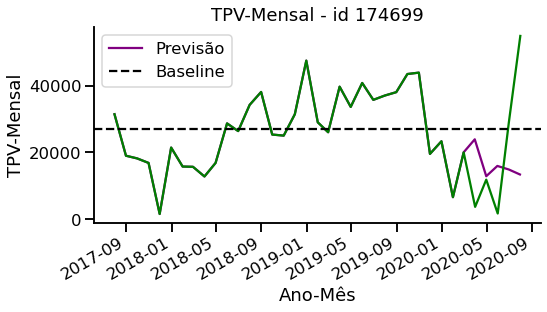

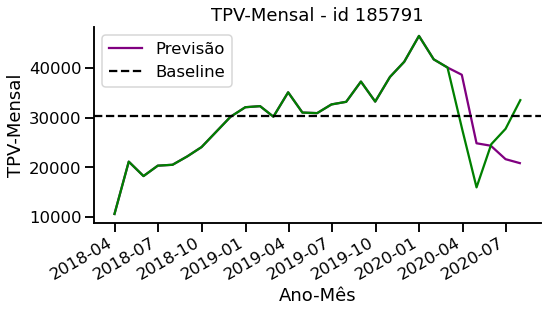

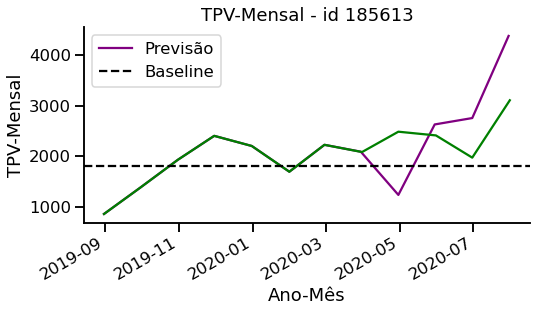

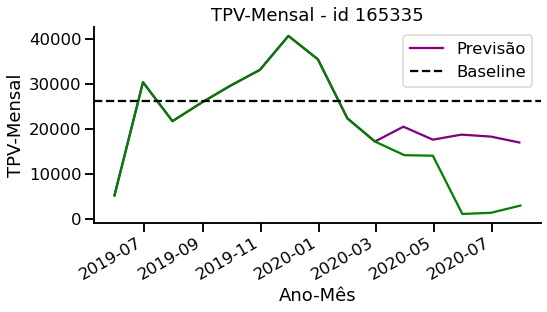

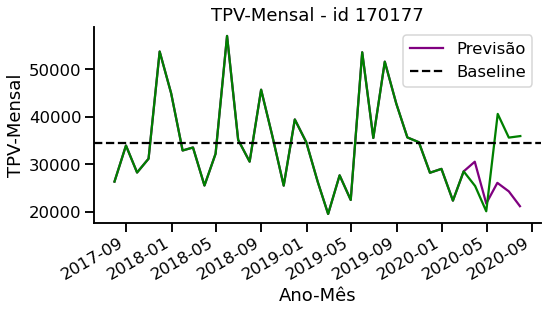

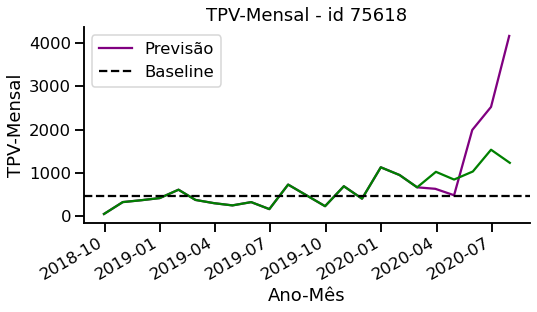

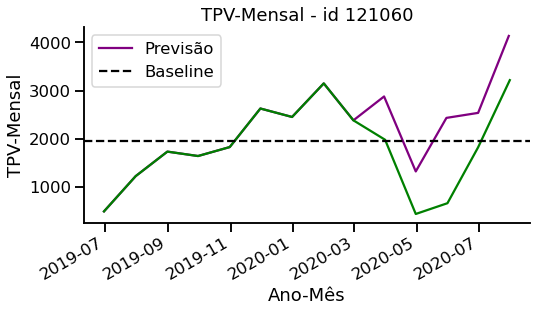

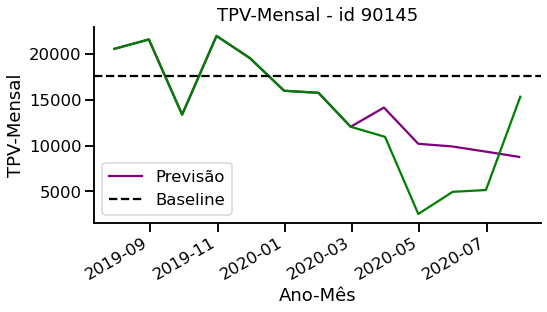

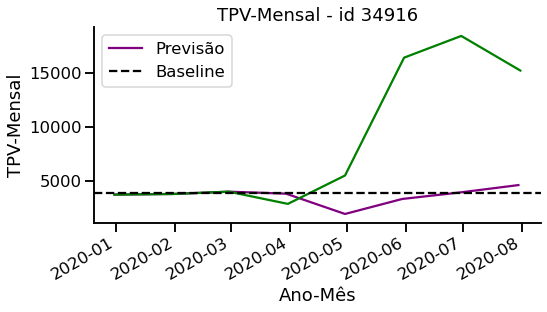

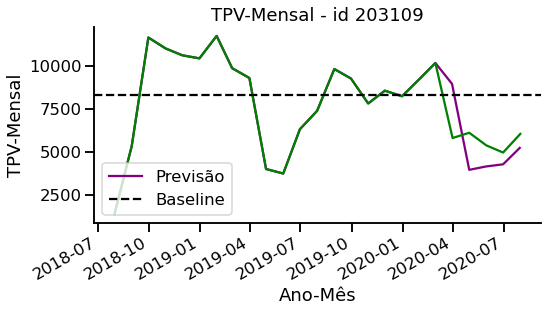

In [61]:
# plotando o dataframe criado pela renovação do modelo

np.random.seed(4853456)
ids = np.random.choice(cb_optuna_result_df.id.unique(), size=10)

for id in ids:
    
    fig, ax = plt.subplots(figsize=(8,4))
    
    # pred data
    df_pred = cb_optuna_result_df[cb_optuna_result_df.id == id][['mes_referencia', 'TPV_mensal']]
    sns.lineplot(x='mes_referencia', y='TPV_mensal', data=df_pred, ax=ax, color='purple', label='Previsão')
    
    # train data  
    df_t = df_modelo[(df_modelo.id == id) & (df_modelo['mes_referencia'] < np.datetime64('2020-08-01'))]
    sns.lineplot(x='mes_referencia', y='TPV_mensal', data=df_t, ax=ax, color='g')
    
    # last months mean
    mean = df_t[df_t['mes_referencia'] < np.datetime64('2020-03-01')]['TPV_mensal'].mean()
    ax.axhline(y=mean, color='k', alpha=1, ls='--', label='Baseline')
    
    # customization
    ax.set(title=f'TPV-Mensal - id {id}',
           xlabel='Ano-Mês',
           ylabel='TPV-Mensal')
    
    plt.legend()
    sns.despine()
    sns.set_context('talk')
    fig.autofmt_xdate()

O modelo obteve resultados melhores que a baseline para alguns clientes e piores para outros. Considerando a natureza da tarefa, fiquei satisfeito com as previsões alcançados pelo modelo.